# Dataset 1 - Regression

## Experiment Details 

The aim of the experiment is to verify if the:
1. ABC_GAN model corrects model misspecification
2. ABC_GAN model performs better and converges faster than a simple C-GAN model

In the experiment we predict the distribution that represents the real data and simulate realistic fake data points
using statistical mode, C-GAN and ABC-GAN model with 3 priors. We analyze and compare their performance using metrics like mean squared error, mean absolute error , manhattan distance and euclidean distance between $y_{real}$ and $y_{pred}$

The models are as follows:

1. The statistical model assumes the distribution $Y=\beta X + \mu$ where $\mu \sim N(0,1)$
2. The Conditional GAN consists of
    1. Generator with 2 hidden layers with 100 nodes each and ReLu activation.
    2. Discriminator with 2 hidden layers with 25 and 50 nodes and ReLu activation. 
    We use Adam's optimser and BCE Logit Loss to train the model. The input to the Generator of the GAN is (x,e) where x are the features and $e \sim N(0,1)$. The discriminator output is linear. 
3. The ABC GAN Model consists of 
    1. ABC generator is defined as follows:
        1. $Y = 1 + \beta_1 x_1 + \beta_2 x_2 + \beta_2 x_3 + ... + \beta_n x_n + N(0,\sigma)$ where $\sigma = 0.1$ 
        2. $\beta_i \sim N(0,\sigma^{*})$ when $\mu = 0$ else $\beta_i \sim N(\beta_i^{*},\sigma^{*})$ where $\beta_i^{*}s$ are coefficients obtained from statistical model
        3. $\sigma^{*}$ takes the values 0.01,0.1 and 1      
    2. C-GAN network is as defined above. However the input to the Generator of the GAN is $(x,y_{abc})$ where $y_{abc}$ is the output of the ABC Generator.
        

## Import Libraries 

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import train_test
import ABC_train_test
import regressionDataset
import network
import statsModel
import performanceMetrics
import dataset
import sanityChecks
import torch 
import matplotlib.pyplot as plt 
import seaborn as sns 
from scipy.stats import norm
from torch.utils.data import Dataset,DataLoader 
from torch import nn

## Parameters

General Parameters 

1. Number of Samples
2. Number of features 

ABC-Generator parameters are as mentioned below: 
1. mean : 1 ($\beta \sim N(\beta^{*},\sigma)$ where $\beta^{*}$ are coefficients of statistical model) or 1 ($\beta \sim N(0,\sigma)$
2. std : $\sigma = 1, 0.1 , 0.01$ (standard deviation)

In [3]:
n_features = 10
n_samples= 100
 
#ABC Generator Parameters
mean = 1 
variance = 0.001

In [4]:
# Parameters
n_samples = 10
n_features = 10
mean = 0
variance = 0.1


## Dataset

Generate a random regression problem

$Y = 1 + \beta_1 x_1 + \beta_2 x_2 + \beta_2 x_3 + ... + \beta_n x_n + N(0,\sigma)$ where $\sigma = 0.1$

In [5]:
X,Y = regressionDataset.regression_data(n_samples,n_features)

         X1        X2        X3        X4        X5        X6        X7  \
0  1.324475  1.652378  0.218102  1.836472  0.605305 -1.830777 -1.034332   
1  0.664141 -0.691010  0.197968  2.053729  0.848687 -0.567405  0.105093   
2 -0.578873  1.200679 -0.492351  0.800202  0.503495  2.161142 -0.277611   
3 -0.255398  1.478666 -1.080265  0.000534 -0.795978  1.081164  0.671336   
4  0.069650  0.800828  1.675007  1.275853 -0.189820  0.240740 -1.367502   

         X8        X9       X10           Y  
0 -0.133915 -0.252321 -0.531306  209.296664  
1 -0.279122  0.234729 -2.457954   47.023476  
2  0.370987 -1.677671 -0.281267  146.543252  
3  2.204717  0.595248 -1.654174  199.473915  
4  0.264739 -1.276690  0.551594  186.544199  


## Stats Model

No handles with labels found to put in legend.


                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Tue, 19 Oct 2021   Prob (F-statistic):                nan
Time:                        23:14:33   Log-Likelihood:                 325.00
No. Observations:                  10   AIC:                            -630.0
Df Residuals:                       0   BIC:                            -627.0
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.776e-17        inf          0        n

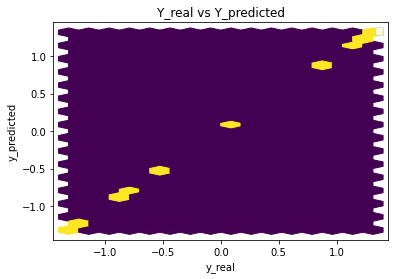

Performance Metrics
Mean Squared Error: 3.452267943913008e-30
Mean Absolute Error: 1.6459056340067945e-15
Manhattan distance: 1.6459056340067946e-14
Euclidean distance: 5.8756003471245454e-15


In [6]:
[coeff,y_pred] = statsModel.statsModel(X,Y)

## Common Training Parameters (GAN & ABC_GAN) 

In [7]:
n_epochs = 5000
error = 0.001
batch_size = n_samples//2

## GAN Model

In [8]:
real_dataset = dataset.CustomDataset(X,Y)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

**Training GAN for n_epochs number of epochs** 

In [9]:
generator = network.Generator(n_features+2)
discriminator = network.Discriminator(n_features+2)

criterion = torch.nn.BCEWithLogitsLoss()
gen_opt = torch.optim.Adam(generator.parameters(), lr=0.01, betas=(0.5, 0.999))
disc_opt = torch.optim.Adam(discriminator.parameters(), lr=0.01, betas=(0.5, 0.999))

In [10]:
print(generator)
print(discriminator)

Generator(
  (hidden1): Linear(in_features=12, out_features=100, bias=True)
  (hidden2): Linear(in_features=100, out_features=100, bias=True)
  (output): Linear(in_features=100, out_features=1, bias=True)
  (relu): ReLU()
)
Discriminator(
  (hidden1): Linear(in_features=12, out_features=25, bias=True)
  (hidden2): Linear(in_features=25, out_features=50, bias=True)
  (output): Linear(in_features=50, out_features=1, bias=True)
  (relu): ReLU()
)


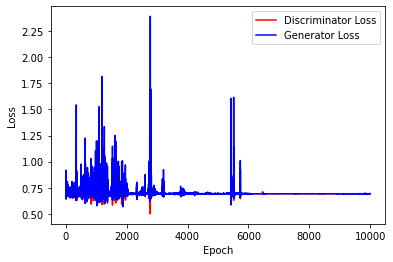

In [11]:
train_test.training_GAN(discriminator,generator,disc_opt,gen_opt,real_dataset,batch_size, n_epochs,criterion,device)

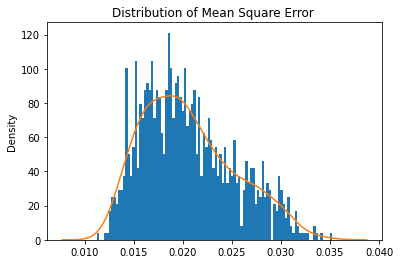

Mean Square Error: 0.02055932578303619


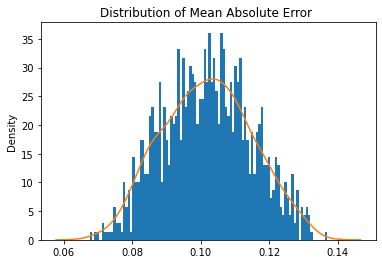

Mean Absolute Error: 0.10195924442708493


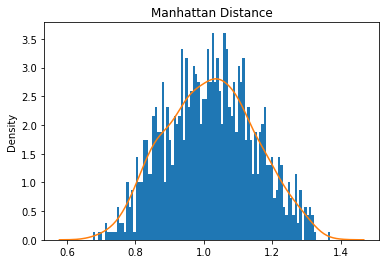

Mean Manhattan Distance: 1.0195924442708493


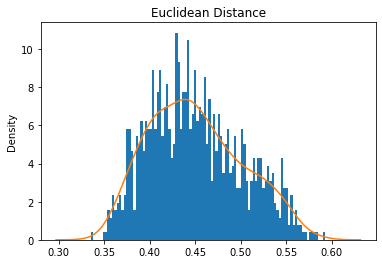

Mean Euclidean Distance: 0.45055580960804203


In [12]:
train_test.test_generator(generator,real_dataset,device)

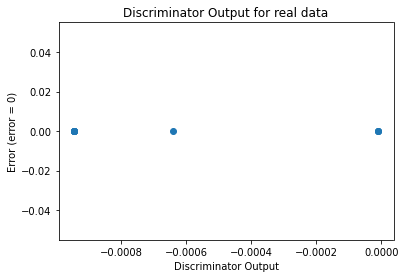

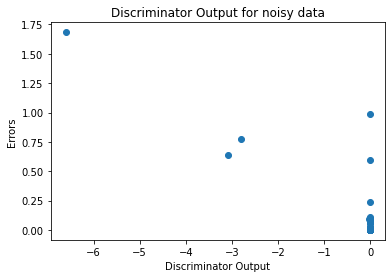

In [13]:
sanityChecks.discProbVsError(real_dataset,discriminator,device)

**Training GAN until mse of y_pred is > 0.1 or n_epochs < 30000**

In [14]:
generator = network.Generator(n_features+2)
discriminator = network.Discriminator(n_features+2)
criterion = torch.nn.BCEWithLogitsLoss()
gen_opt = torch.optim.Adam(generator.parameters(), lr=0.01, betas=(0.5, 0.999))
disc_opt = torch.optim.Adam(discriminator.parameters(), lr=0.01, betas=(0.5, 0.999))

Number of epochs needed 637


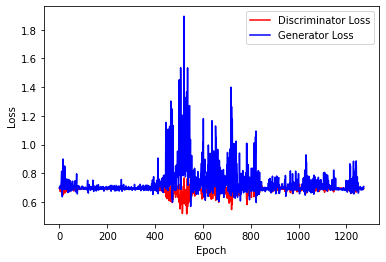

In [15]:
train_test.training_GAN_2(discriminator,generator,disc_opt,gen_opt,real_dataset,batch_size,error,criterion,device)

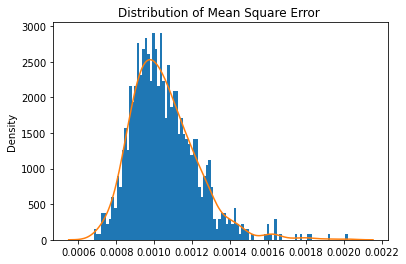

Mean Square Error: 0.0010516742954311067


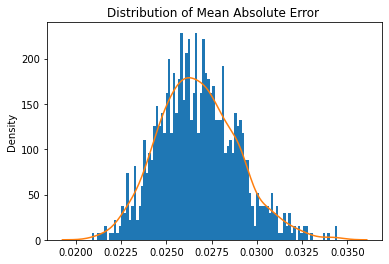

Mean Absolute Error: 0.026742314366996287


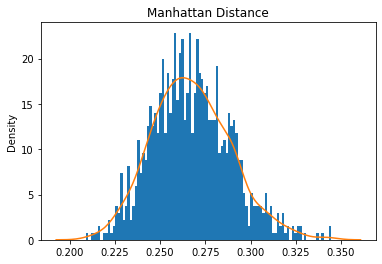

Mean Manhattan Distance: 0.2674231436699629


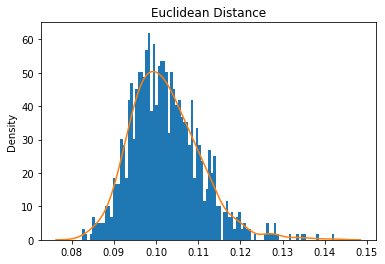

Mean Euclidean Distance: 0.10221661872586299


In [16]:
train_test.test_generator(generator,real_dataset,device)

# ABC GAN Model

### Training the network
**Training ABC-GAN for n_epochs number of epochs** 

In [17]:
gen = network.Generator(n_features+2)
disc = network.Discriminator(n_features+2)

criterion = torch.nn.BCEWithLogitsLoss()
gen_opt = torch.optim.Adam(gen.parameters(), lr=0.01, betas=(0.5, 0.999))
disc_opt = torch.optim.Adam(disc.parameters(), lr=0.01, betas=(0.5, 0.999))

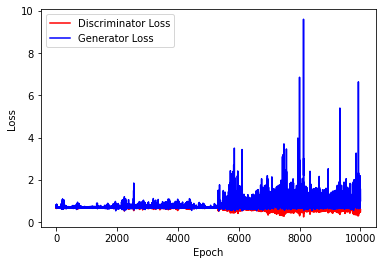

In [18]:
ABC_train_test.training_GAN(disc, gen,disc_opt,gen_opt,real_dataset, batch_size, n_epochs,criterion,coeff,mean,variance,device)

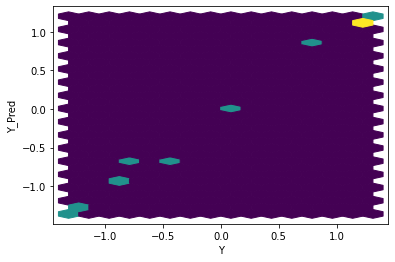

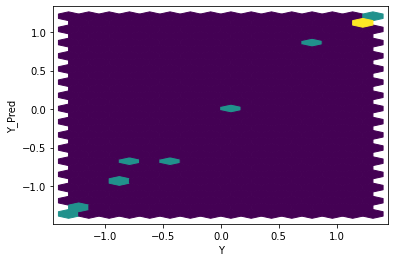

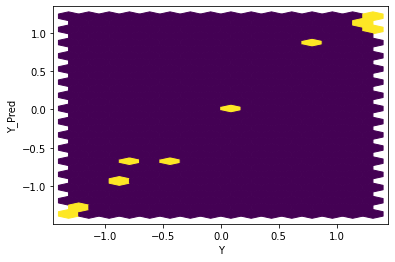

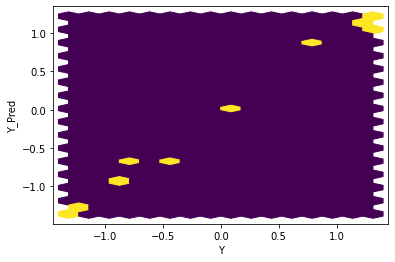

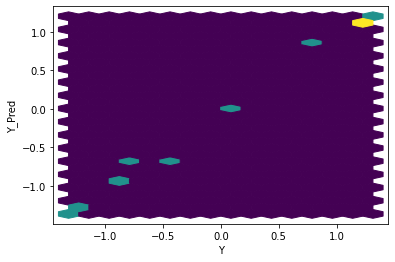

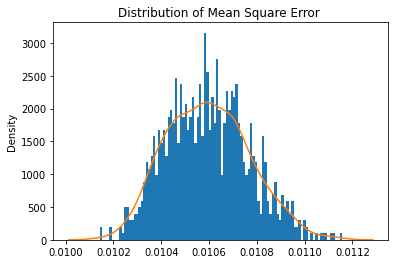

Mean Square Error: 0.010595261472349665


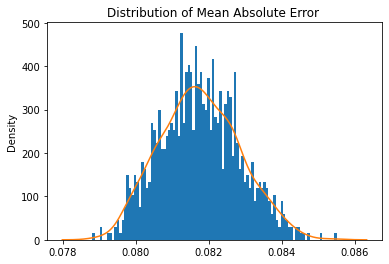

Mean Absolute Error: 0.08175465989708901


Mean Manhattan Distance: 0.81754659897089


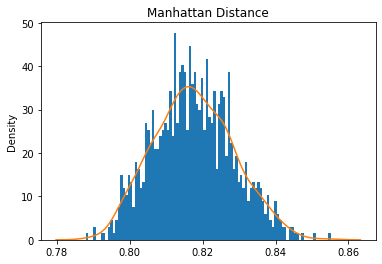

Mean Euclidean Distance: 0.32549290231290606


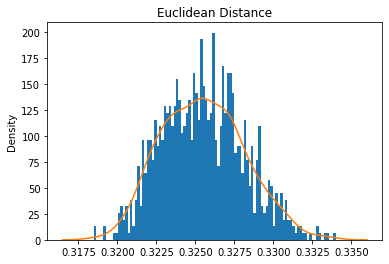

In [19]:
ABC_train_test.test_generator(gen,real_dataset,coeff,mean,variance,device)

#### Sanity Checks 

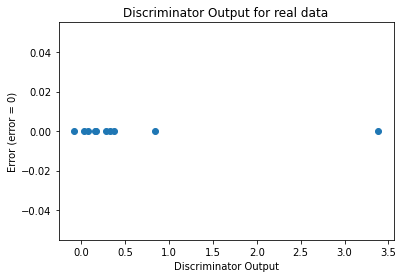

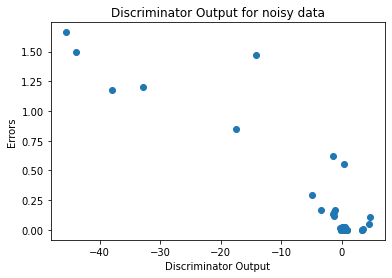

In [20]:
sanityChecks.discProbVsError(real_dataset,disc,device)

**Training GAN until mse of y_pred is > 0.1 or n_epochs < 30000**

In [21]:
gen = network.Generator(n_features+2)
disc = network.Discriminator(n_features+2)

criterion = torch.nn.BCEWithLogitsLoss()
gen_opt = torch.optim.Adam(gen.parameters(), lr=0.01, betas=(0.5, 0.999))
disc_opt = torch.optim.Adam(disc.parameters(), lr=0.01, betas=(0.5, 0.999))

Number of epochs 30000


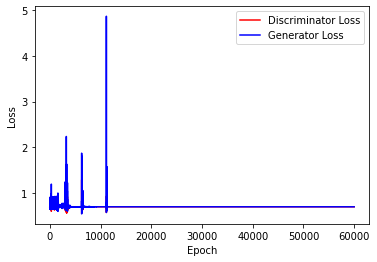

In [22]:
ABC_train_test.training_GAN_2(disc,gen,disc_opt,gen_opt,real_dataset,batch_size, error,criterion,coeff,mean,variance,device)

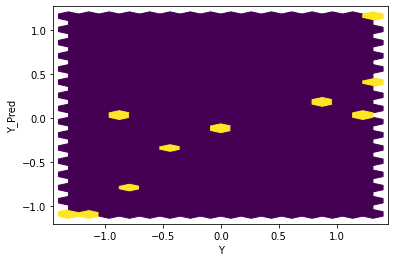

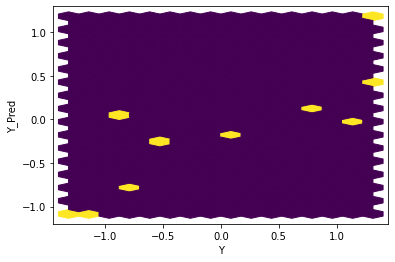

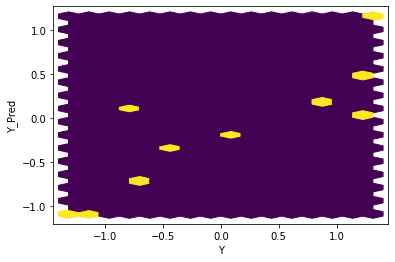

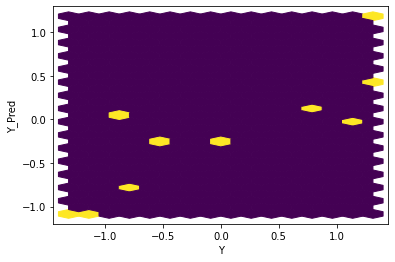

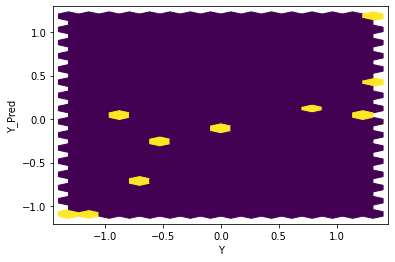

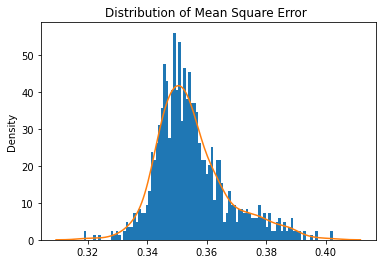

Mean Square Error: 0.35500543258637374


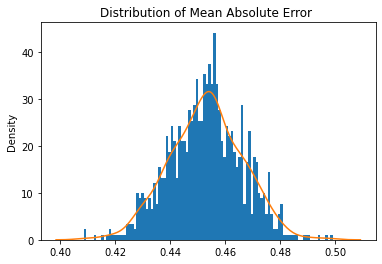

Mean Absolute Error: 0.45310171249508857
Mean Manhattan Distance: 4.5310171249508855


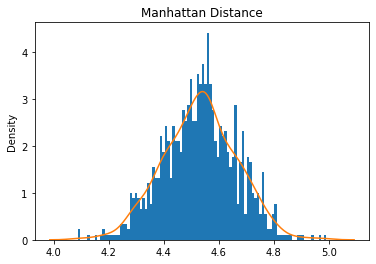

Mean Euclidean Distance: 1.8838821205498824


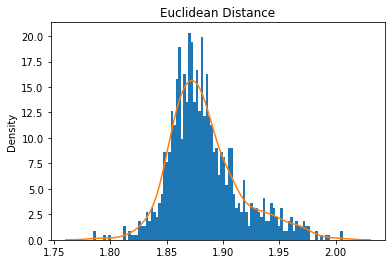

In [23]:
ABC_train_test.test_generator(gen,real_dataset,coeff,mean,variance,device)